In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.optimize import curve_fit
Z = 16

In [2]:
covid = pd.read_csv("Coronavirus_Italy.csv")
inf_col = "Infected"

In [3]:
covid.head()

,Date,Infected,Dead,Recovered,Total
0,2/22/2020,76,2,1,79
1,2/23/2020,146,3,1,150
2,2/24/2020,221,7,1,229
3,2/25/2020,309,11,1,321
4,2/26/2020,385,12,3,400


In [4]:
covid.tail()

,Date,Infected,Dead,Recovered,Total
23,3/16/2020,23073,2158,2749,27980
24,3/17/2020,26062,2503,2941,31506
25,3/18/2020,28710,2978,4025,35713
26,3/19/2020,33190,3405,4440,41035
27,3/20/2020,37860,4032,5129,47021


In [6]:
covid.iloc[16]

Date         3/9/2020
Infected         7985
Dead              463
Recovered         724
Total            9172
Name: 16, dtype: object

In [7]:
R0=2.8
N0 = 60.48
dh = 0.05

In [8]:
def S_der(S, I, gamma, R0=R0, N=N0):
    return -R0*gamma*I*S/N

def I_der(I, S, gamma, R0=R0, N=N0):
    return R0*gamma*I*S/N - gamma*I

def R_der(R, I, gamma):
    return gamma*I

In [9]:
def euler(now, der_func, dh, *args):
    return now + dh*der_func(now, *args)

def midpoint(now, der_func, dh, *args):
    return now + dh*der_func(now+dh/2*der_func(now, *args), *args)

In [10]:
def pred_infected(times, gamma):
    S, I, R = [N0], [covid[inf_col][0]/10**6], [covid['Recovered'][0]/10**6]
    integration_times = np.arange(0, times[-1]+dh, dh)
    infected = []
    for i, time in enumerate(integration_times):
        new_s = midpoint(S[i], S_der, dh, I[i], gamma)
        new_i = midpoint(I[i], I_der, dh, S[i], gamma)
        new_r = midpoint(R[i], R_der, dh, I[i], gamma)
        
        S.append(new_s)
        I.append(new_i)
        R.append(new_r)
        
        if time in times:
            infected.append(I[i])
    infected = np.array(infected)
    return infected

def pred_recovered(times, gamma):
    S, I, R = [N0], [covid[inf_col][0]/10**6], [covid['Recovered'][0]/10**6]
    integration_times = np.arange(0, times[-1]+dh, dh)
    recovered = []
    for i, time in enumerate(integration_times):
        new_s = midpoint(S[i], S_der, dh, I[i], gamma)
        new_i = midpoint(I[i], I_der, dh, S[i], R[i], gamma)
        new_r = midpoint(R[i], R_der, dh, I[i], gamma)
        
        S.append(new_s)
        I.append(new_i)
        R.append(new_r)
        
        if time in times:
            recovered.append(R[i])
    recovered = np.array(recovered)
    return recovered

[0.13152774] [7.60295908]


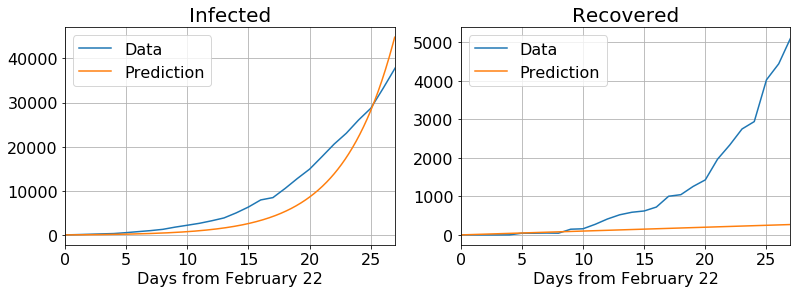

In [12]:
p0 = (0.1)
popt, pcov = curve_fit(pred_infected, covid.index.values, covid[inf_col]/10**6, p0=p0)
print(popt, 1/popt)
smooth_times = np.arange(0, covid.index.values[-1], dh)
infected = pred_infected(smooth_times, *popt)
recovered = pred_recovered(smooth_times, *popt)

fig, axs = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
axs[0].set_title("Infected", fontsize=Z+4)
axs[0].plot(covid.index, covid[inf_col], label="Data")
axs[0].plot(smooth_times, infected*10**6, label="Prediction")
axs[1].set_title("Recovered", fontsize=Z+4)
axs[1].plot(covid.index, covid['Recovered'], label="Data")
axs[1].plot(smooth_times, recovered*10**6, label="Prediction")
for ax in axs.flatten():
    ax.set_xlim(0,max(smooth_times))
    ax.set_xticks(np.arange(0, max(smooth_times)+1,5))
    ax.grid()
    ax.tick_params(labelsize=Z)
    ax.set_xlabel("Days from February 22", fontsize=Z)
    ax.legend(fontsize=Z)
plt.show()
plt.close()